**研究目的：**

本文参考海通证券冯佳睿、袁林青撰写的《选股因子系列研究(十八)——价格形态选股因子》，根据研报分析，主要测试了开盘冲高、盘低回升以及均价偏离这三种价格类因子。基于该文章，本文对文章中提到的三种价格类因子进行因子有效性分析，从而实现对股票未来收益的预测，为 alpha 因子的挖掘提供了一定思路。

**研究内容：**

（1）构建分别以月和半月为观察期的三种价格类因子；
（2）对构建出来的因子进行因子有效性分析，分别包括因子 IC/IR 分析，分层回测组合分析等，并根据结果分析因子的预测能力以及不同观察期对预测能力的影响；
（3）对每个因子，加入行业、市值、贝塔、动量、残差波动率以及非线性市值这 6 个因子进行正交化处理，分析正交化后因子对组合收益的贡献及其预测效果；
（4）对因子进行多因子模型回测分析，分析不同因子对组合收益带来的贡献等。

**研究结论：**

（1）通过对这三种价格类因子的因子有效性分析结果来看，三种因子均有较好的选股能力，针对不同的观察期，月度因子比半月度因子具有更强的选股能力，但是相对而言，这三种因子的分层回测单调性不足；
（2）通过将这三种因子与行业、市值、贝塔、动量、残差波动率以及非线性市值这 6 个因子进行正交化处理，分析结果可知正交化因子预测稳定性得到较大提升，因子的分层回测单调性得到增强；
（3）对多因子模型进行回测分析，分别从横截面收益率回归和纯多头组合这两方面进行分析，根据分析结果来看，在加入因子 HighOpen 或者因子 VwapClose 后，模型收益能力和风险控制能力相比原始模型均得到了较大提升。

## 1 因子构建
通过对 K 线的研究，不难发现，常见价格信息，如高、开、低、收等，也能够很好地实现对股票收益的刻画，且对于大多数散户而言，K 线是其主要研究对象，从中提取特征信息，如 K 线的上影线、下影线等等。
参考研报内容，考虑引入开盘、盘高、盘低以及均价构建相关指标刻画股票日内的形态特征。共引入三个指标：开盘冲高、盘低回升以及均价偏离。具体指标计算方式如下所示：
（1）开盘冲高：log(盘高/开盘价)。该指标越大，表示股票盘中冲高幅度越大。
（2）盘低回升：log(收盘价/盘低)。该指标越大，表示股票从盘低回升的幅度也就越大。
（3）均价偏离：log(均价/收盘价)。该指标体现了股票成交均价相对于收盘价的偏离。
紧接着，设计因子实现上述指标，在每个月或者每半个月的时间窗口下，计算上述三个因子过去 1 个月或者半个月的均值，具体计算公式如下所示：
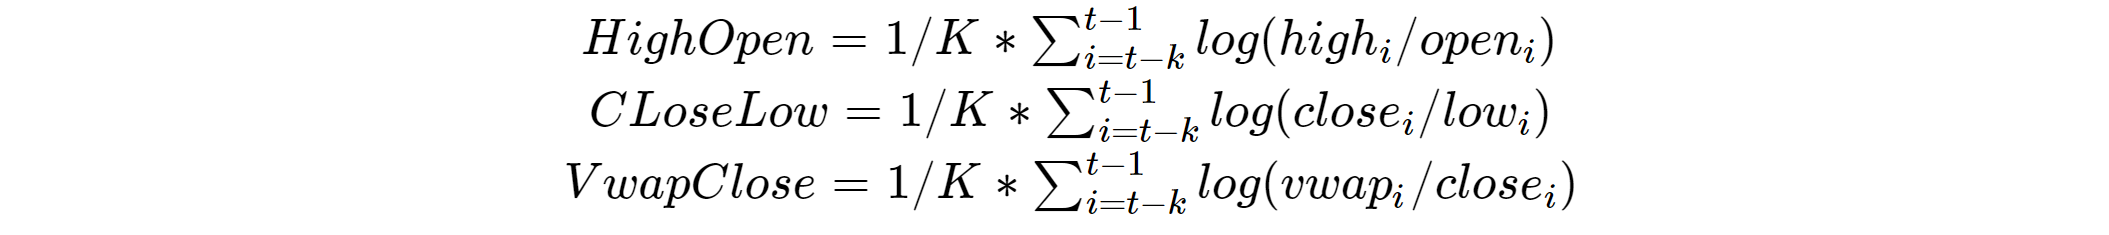

#### 1.1 日期列表获取
在每个月的月末对因子数据进行提取，因此需要对每个月的月末日期进行统计。
输入参数分别为 peroid、start_date 和 end_date，其中 peroid 进行周期选择，可选周期为周(W)、月(M)和季(Q)，start_date和end_date 分别为开始日期和结束日期。
函数返回值为对应的日期。本文选取开始日期为 2013.1.1，结束日期为 2018.1.1。周期如月取 “W”，半月取 “2W”。

In [ ]:
import alphalens
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

#正常显示画图时出现的中文和负号
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False
#还是使用tushare获取数据
import tushare as ts
token='ffc714ffff21ebeaac6ef3cbf0db7bd557634cdaf1c5cc95afb0f35e'
pro=ts.pro_api(token)
#获取当前交易的股票代码和名称
def get_code():
    df = pro.stock_basic(exchange='', list_status='L')
    #剔除2017年以后上市的新股次新股
    df=df[df['list_date'].apply(int).values<20170101]
    #剔除st股
    df=df[-df['name'].apply(lambda x:x.startswith('*ST'))]
    codes=df.ts_code.values
    return codes 
df=pro.daily_basic(ts_code=get_code()[0],start_date='20110101')
for code in get_code()[1:]:
    df1=pro.daily_basic(ts_code=code,start_date='20110101')
    df=pd.concat([df,df1])
df_new=df.loc[:,['ts_code','trade_date','close','pe_ttm']]
df_new.loc[:,'trade_date']=pd.to_datetime(df_new.trade_date)
#设定双重重索引的数据格式
df_new=df_new.set_index(['trade_date','ts_code'])
#根据第一索引排序
df_new=df_new.sort_index()
#查看数据前几行
df_new.head()